In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D # type: ignore
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy # type: ignore

import utils # all data reading and preprocessing functionality

In [3]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract'
label_selection = 'label' # can be 'label' or 'text_label'

In [4]:
df = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
#utils.preprocess_text(data) # can be skipped here?

df.head()

,pmid,title,abstract,label,text_label
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control


In [5]:
# number of classes
K = df[label_selection].max() + 1
K

2

In [6]:
df_train, df_test = train_test_split(df[[data_selection, 'label', 'text_label']], test_size=0.3)
df_train.head()

,abstract,label,text_label
7913,The development of hybrid nanostructures of gr...,1,pesticide
4642,Fish from western Lake Superior (1972-73) cont...,1,pesticide
3814,Intravenous (IV) drug administration enables t...,0,control
6610,BACKGROUND/PURPOSE: The anorectal spasticity i...,1,pesticide
6009,The development of fungal biocontrol agents (B...,1,pesticide


In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) # tokenizer from tensorflow.keras.preprocessing.text
tokenizer.fit_on_texts(df_train[data_selection])
sequences_train = tokenizer.texts_to_sequences(df_train[data_selection]) # returns a simple python list of lists (of numbers)
sequences_test = tokenizer.texts_to_sequences(df_test[data_selection])

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 51085 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (6377, 1846)


In [10]:
# also pad the test sequences. Note that we use the same T as for the training data
# (this is important!)
data_test = pad_sequences(sequences_test, maxlen=T)

print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (2733, 1846)


In [ ]:
# Create the model

# Embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

## Exercise: try other models
1) multiple LSTM layers  
2) GRU instead of LSTM  
3) SimpleRNN instead of LSTM  
4) return_sequences=False, and no maxpool  -> This will only keep the final hidden state
5) For 1-4, try different values of number of hidden units  
6) Combinations of the above  

### Common beginner question:
"how can I choose the best combination of hyperparameters?"  
This is how! There is no shortcut!  

In [12]:
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) # these are the default values

# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=optm,
  metrics=['accuracy']
)

In [24]:
print('Training model...') # This takes a really long time!
r = model.fit(
  data_train,
  df_train['label'],
  epochs=30, #50,
  validation_data=(data_test, df_test['label'])
)

Training model...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 398ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9389 - val_loss: 0.2675
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - accuracy: 0.9761 - loss: 0.1271 - val_accuracy: 0.9561 - val_loss: 0.1325
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 393ms/step - accuracy: 0.9845 - loss: 0.0461 - val_accuracy: 0.9601 - val_loss: 0.1179
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - accuracy: 0.9932 - loss: 0.0219 - val_accuracy: 0.9217 - val_loss: 0.2340
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 401ms/step - accuracy: 0.9933 - loss: 0.0226 - val_accuracy: 0.9572 - val_loss: 0.1406
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 397ms/step - accuracy: 0.9975 - loss: 0.0116 - val_accuracy: 0.9583 - val_loss: 0.1647
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 395ms/step - accuracy: 0.9970 - loss: 0.0120 - val_accuracy: 0.9561 - val_loss: 0.1477
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - accuracy

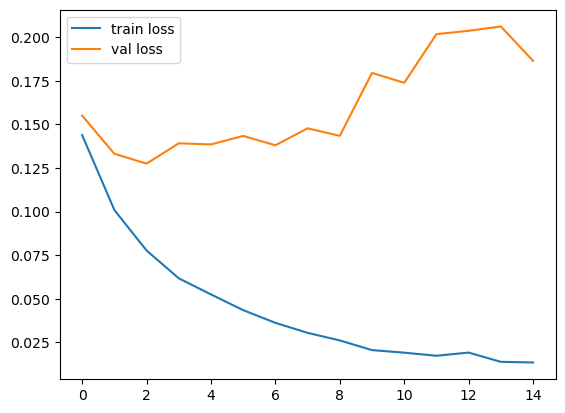

In [15]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

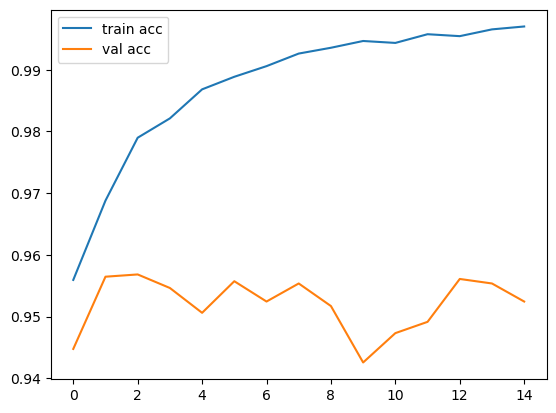

In [16]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [17]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
#P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
P_train = (model.predict(data_train) > 0) * 1.0
P_train = P_train[:, 1] # only positive class

#P_test = ((model.predict(data_test > 0) * 1.0).flatten())
P_test = (model.predict(data_test) > 0) * 1.0
P_test = P_test[:, 1] # only positive


200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


In [20]:
cm_train = confusion_matrix(df_train['label'], P_train, normalize='true')
cm_train

array([[9.97421850e-01, 2.57815018e-03],
       [9.16310324e-04, 9.99083690e-01]])

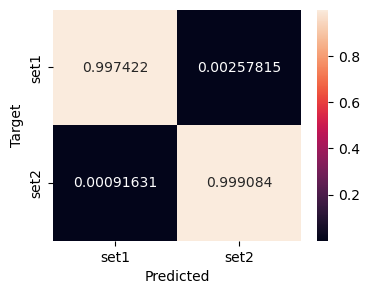

In [21]:
utils.plot_confusion_matrix(cm_train, ['set1', 'set2'])

In [22]:
cm_test = confusion_matrix(df_test['label'], P_test, normalize='true')
cm_test

array([[0.95741445, 0.04258555],
       [0.05430183, 0.94569817]])

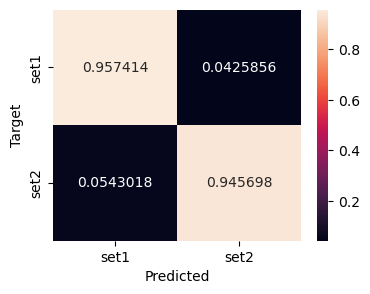

In [23]:
utils.plot_confusion_matrix(cm_test, ['set1', 'set2'])